# Introduction and Motivation
The following notebook is a prototype for a model to be used in predicting racism based on survey responses. Using responses from this question, we will apply the following model to and identify those at risk of racism

# Broad Idea
The broad overview of this model would be to apply Latent Semantic Analysis (LSA), following by mapping the results onto a graph using MDS and pairwise distances between words. Following this, we would try to linearly seperate groups of words into classes of either "Risk of Attrition" or "No risk".

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import pandas as pd
import psycopg2
import string
import re
from gensim import corpora
from gensim.models import Phrases
from gensim.models import TfidfModel, LogEntropyModel
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from scipy.spatial.distance import squareform,pdist
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from tqdm.auto import tqdm as tqdm
from textblob import TextBlob

DIR_NAME = './lsa_mds_plots'
np.random.seed(0)

# Data Retrieval and Preprocessing
Using data from the [redacted], we choose the question [redacted]. We would try to categorize each response ("document") into 3 buckets: "Has personal experience with racism", "Has witnessed racism, but not personally", and "Has not gone through nor witnessed racism".

[Data Retrieval Code redacted]

We first calculate the polarity of each document (-1: Strongly Negative to 1: Strongly Positive). We do this so we can visualize on the graph if any clusters of sentiment, and easily come up with lines that will seperate the data. 

Since we are going to be plotting words, we must attribute a polarity score to each word. To do this, we average the polarities of documents in which the word appears, and use this value as the word's polarity

In [3]:
def label_documents(data):
    labels = []
    sent = SentimentIntensityAnalyzer()

    for doc in data:
        polarity = TextBlob(doc).sentiment.polarity
        labels.append(polarity)
    return labels

def label_words(dictionary, bow, doc_labels):
    dict_values = list(dictionary.values())
    dict_keys = list(dictionary.keys())
    word_labels = np.array([[0,0]] * len(dictionary)).astype('float32')
    for i, row in enumerate(bow):
        for word_idx, count in row: # average of polarities
            word_labels[word_idx][0] += count * doc_labels[i]
            word_labels[word_idx][1] += count
    word_labels[:,0] = word_labels[:,0] / word_labels[:,1] 
    return word_labels[:,0]

Next, we preprocess the data by removing apostrophes, lemmatize the documents, applying ngrams, etcs.

In [4]:
def remove_apostrophe(s):
    s = str(s).lower()
    s = re.sub('’', '', s)
    s = re.sub(r"won't", "will not", s)
    s = re.sub(r"can\'t", "can not", s)
    s = re.sub(r"n\'t", " not", s)
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"\'d", " would", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'m", " am", s)
    s = re.sub('&', "and", s)
    s = re.sub('"', ' ', s)
    s = re.sub('/', ' or ', s)
    s = re.sub('\(', ' ', s)
    s = re.sub('\)', ' ', s)
    return s

def preprocess_data(data, preprocess_method):
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english') + ['kinross'])
    text_norm = str
    if preprocess_method == 'stem':
        p_stemmer = PorterStemmer()
        text_norm = p_stemmer.stem
    elif preprocess_method == 'lem':
        lemmatizer = WordNetLemmatizer()
        text_norm = lemmatizer.lemmatize
    else:
        raise Exception('Unsupported text preprocess method')
    texts = []
    for i in data:
        raw = remove_apostrophe(i.lower())
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        normed_tokens = [text_norm(i) for i in stopped_tokens if i not in string.punctuation and not i.isdigit()]
        texts.append(normed_tokens)
    return texts

def apply_ngrams(texts):
    bigram_transformer = Phrases(texts)
    bigram_token = []
    for sent in texts:
        bigram_token.append(bigram_transformer[sent])
    return bigram_token

# Bag-of-Words
Using the preprocessed data, we build a bag-of-words (BOW) model. Using the result from gensim, we create a nxm matrix, where n is the number of unique words, and m being the number of documents.

We also apply 1 of 3 possible weighting schemes to the BOW
1. Log-entropy weighting (Dumais, 1991; Martin & Berry, 2007) is applied to this matrix to strengthen the impact of low-frequency words while weakening the impact of high-frequency words, since low-frequency words typically have a narrower, more defined and specific meaning. 
2. TF-IDF
3. No weighting scheme

Thus we get a matrix whose rows represent words, columns representing documents, and each i,jth cell represent the number of times word i appears in document j

In [5]:
def prepare_corpus(texts):
    dictionary = corpora.Dictionary(texts)
    bow = [dictionary.doc2bow(doc) for doc in texts]
    return dictionary, bow

def apply_weighting_scheme(bow, weight_scheme):
    weight_model = []
    if weight_scheme == 'logentropy':
        weight_model = LogEntropyModel(bow)
    elif weight_scheme == 'tfidf':
        weight_model = TfidfModel(bow)
    elif weight_scheme == 'none':
        return bow
    else:
        raise Exception('Unsupported weight scheme')
    weighted_bow = []
    for doc in bow:
        vector = weight_model[doc]
        weighted_bow.append(vector)
    return weighted_bow

def create_bow_matrix(bow, dictionary):
    matrix = []
    for doc in bow:
        row = [0] * len(dictionary)
        for word in doc:
            row[word[0]] = word[1]  # set the frequency of the word
        matrix.append(row)
    return np.array(matrix).T

# SVD, LSA and MDS
Using this matrix, we apply SVD. Recovering information from SVD (UE_rV^T) is called LSA. After performing LSA, we normalize the matrix and compute either pairwise euclidean distances, or 2-2* cosine distances. 

In [6]:
def apply_svd(matrix, r):
    u, s, vh = np.linalg.svd(matrix, full_matrices=True, compute_uv=True)
    # Write Σr for the matrix obtained by setting all but the r largest singular values in Σ to 0
    # s_r = (s >= s[r - 1]) * s
    # X_r = np.dot(u * s_r, vh)
    X_r = u[:, :r] @ np.diag(s[:r]) @ vh[:r, :]
    return X_r

def normalize(matrix, method):
    res = []
    if method == 'l1' or method == 'l2':  # l1 or l2
        res = preprocessing.normalize(matrix, norm=method)
    else:
        raise Exception('Unsupported normalization method')
    return res

def compute_distances(matrix, method):
    if method == 'cosine':
        dis = 2 - 2 * cosine_similarity(matrix)
    else:
        dis = squareform(pdist(matrix,method))
    return dis

Lastly, we apply MDS or T-SNE on the normalized matrix

In [7]:
def reduce_dims(X, method):
    red = None
    if method == 'mds':
        red = MDS(n_components=100, random_state=0, dissimilarity='precomputed')
    elif method == 'tsne':
        red = TSNE(n_components=2, random_state=0)
    X_2d = red.fit_transform(X)
    return X_2d

In [8]:
def apply_tsne(X, dictionary):
    tsne = TSNE(n_components=100, random_state=0)
    X_2d = tsne.fit_transform(X)
    return X_2d

# Visualization
After this, we can plot the result of MDS of words. The graph will be colored such that words which strongly negative polairties will be red, and green for strongly positive words.

In [9]:
def plot_polarity(X, num_clusters, clustering_algo, dictionary, save_fig_name, labels, desc, save=False):
    y_km = labels

    fig = plt.figure(figsize=(15, 15))
    gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
    axes = gs.subplots()

    def distance(p1, p2):
        return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

    def closest(pt, others):
        return min(others, key = lambda i: distance(pt, i))

    all_points = []
    distances = dict()
    x, y = X[:,0], X[:,1]

    for _x, _y, _s in zip(x, y, dictionary.values()):
        all_points.append((_x, _y))

    left, width = 0, .5
    bottom, height = -0.1, .5
    right = left + width
    top = bottom + height
#     scatter = axes[0].scatter(X[:,0], X[:,1],s=50, c=y_km, cmap='RdYlGn', edgecolor='black')
    scatter = axes.scatter(X[:,0], X[:,1],s=50, c=y_km, cmap='RdYlGn', edgecolor='black')
    axes.text(left, bottom, desc, horizontalalignment='left', verticalalignment='top',transform=axes.transAxes, size=15)

    axins1 = inset_axes(axes, width='10%', height='2%', loc='lower right')
    cbar = fig.colorbar(scatter, cax=axins1, orientation='horizontal', ticks=[-1, 1])
    cbar.ax.set_xticklabels(['-1', '1'])
    cbar.ax.set_title('Words Polarities')
    axins1.xaxis.set_ticks_position('top')
    
    for _x, _y, _s in zip(x, y, dictionary.values()):
        curr_point = (_x, _y)
        if curr_point not in distances:
            # make a copy and remove the current point from the list
            all_but_curr = all_points[:]
            try:
                del all_but_curr[all_but_curr.index((curr_point))]
            except:
                pass
            closest_point = closest(curr_point, all_but_curr)
            distance_to_closest = distance(curr_point, closest_point)
            distances[curr_point] = distance_to_closest
        else:
            distance_to_closest = distances[curr_point]
        if np.random.rand() > .90 and distance_to_closest > 0.01:
            axes.text(_x, _y, _s)

                
    clusters = dict()
    for i, l in enumerate(y_km):
        if l not in clusters:
            clusters[l] = []
        clusters[l].append(dictionary[i])

#     axes[0].set_title(save_fig_name)
    axes.set_title(save_fig_name)
    if save:
        plt.savefig(save_fig_name)
    return axes, fig

This cell can be run to generate multiple graphs from different models based on parameters

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


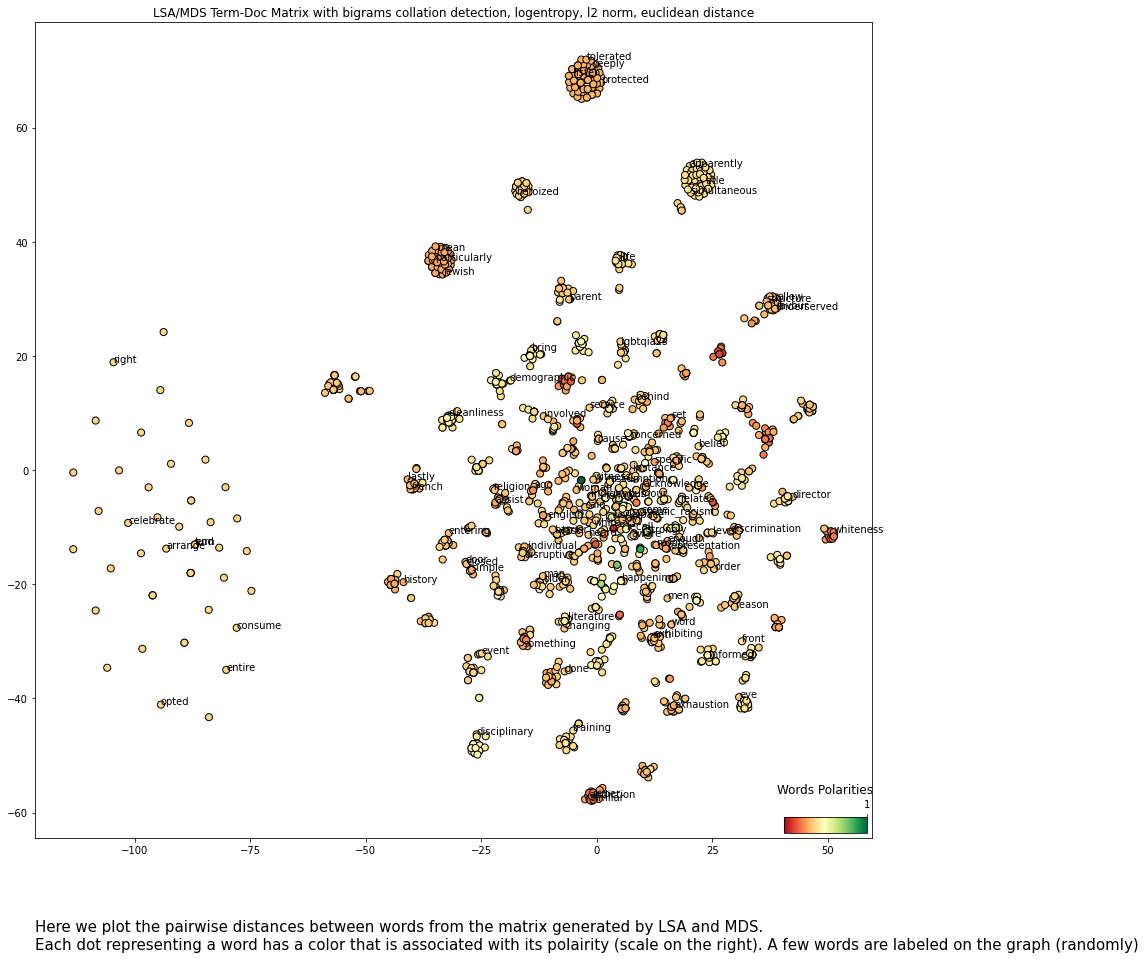

In [10]:
# Possible Options
#     'weight_scheme': ['tfidf', 'logentropy', 'none'],
#     'norm_method': ['l1', 'l2'],
#     'distance_method': ['euclidean', 'cosine'],
#     'preprocess_method': ['lem'],
#     'collation_detect': ['bigrams'],
#     'num_clusters': [3],
#     'clustering_algo': ['polarity'],
#     'plot': ['word'],
#     'dim_red': ['mds', 'tsne']

param_grid = {
    'weight_scheme': ['logentropy'],
    'norm_method': ['l2'],
    'distance_method': ['euclidean'],
    'preprocess_method': ['lem'],
    'collation_detect': ['bigrams'],
    'num_clusters': [3],
    'clustering_algo': ['polarity'],
    'plot': ['word'],
    'dim_red': ['tsne']
}

params = list(ParameterGrid(param_grid))
filenames = []
with tqdm(total=len(params), leave=True) as pbar:
    for param in params:
        survey = param['survey']
        weight_scheme = param['weight_scheme']
        norm_method = param['norm_method']
        distance_method = param['distance_method']
        preprocess_method = param['preprocess_method']
        collation_detect = param['collation_detect']
        num_clusters = param['num_clusters']
        clustering_algo = param['clustering_algo']
        plot = param['plot']
        dim_red = param['dim_red']

        DIR_NAME = f'./lsa_mds_plots/{survey}_{plot}_{preprocess_method}_{weight_scheme}_{norm_method}_{distance_method}_{collation_detect}_{num_clusters}cl_{clustering_algo}/'
        if not os.path.exists(DIR_NAME):
            os.makedirs(DIR_NAME)

        data = get_data(survey)

        doc_labels = label_documents(data)
        texts = preprocess_data(data, preprocess_method)

        ngram_texts = apply_ngrams(texts)
        dictionary, bow = prepare_corpus(ngram_texts)


        weighted_bow = apply_weighting_scheme(bow, weight_scheme)
        matrix = create_bow_matrix(weighted_bow, dictionary)


        labels = label_words(dictionary, bow, doc_labels)

        smoothed_matrix = apply_svd(matrix, 100)

        normalized_matrix = normalize(smoothed_matrix, norm_method)
        word_distances = compute_distances(normalized_matrix, distance_method)

        X_2d = reduce_dims(word_distances, dim_red)

        save_fig_name = ''
        desc = 'Here we plot the pairwise distances between words from the matrix generated by LSA and MDS. \nEach dot representing a word has a color that is associated with its polairity (scale on the right). A few words are labeled on the graph (randomly)'
        axes, fig = plot_polarity(X_2d, num_clusters, clustering_algo, dictionary, save_fig_name, labels, desc, save=False)
        axes.set_title(f'LSA/MDS Term-Doc Matrix with {collation_detect} collation detection, {weight_scheme}, {norm_method} norm, {distance_method} distance')

        pbar.update()

# Plotting Responses
We can also plot individual documents onto the graph produced above. We can highlight on the graph words that appear in a given document, and also plot the midpoint of all of these words. This midpoint will be used to determine whether a document is to a certain side of a linear seperator later.

In [11]:
def distance(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def plot_response(data, doc_idx, bow, labels, X_2d, num_clusters, clustering_algo, doc_labels, save_fig_name, desc):
    if doc_labels[doc_idx] == 0:
        return

    points = []
    dists = []
    axes = None
    for word_idx, freq in bow[doc_idx]:
        points.append(list(X_2d[word_idx]))

    if len(points) > 0:
        points = np.array(points)
        dists = np.array(dists)
        
        axes, fig = plot_polarity(X_2d, num_clusters, clustering_algo,
                             dictionary, save_fig_name, labels, desc, save=False)
        axes.set_title(f'Document {doc_idx} plotted onto the MDS graph.')
        axes.scatter(points[:, 0], points[:, 1], s=150,
                        c='magenta', edgecolor='black', label=f'Words Appearing in Document {doc_idx}')
        center = [np.mean(points[:, 0]), np.mean(points[:, 1])]
        axes.scatter(center[0], center[1], s=250,
                        c='cyan', edgecolor='black', label=f'Center of Words in Document {doc_idx}')
        axes.legend()
        ans = ''
        ans_split = data[doc_idx].split(" ")
        for i, word in enumerate(ans_split):
            ans += ' ' + word
            if i % 17 == 0 and i != 0:
                ans += '\n'
    return axes, fig
#         plt.savefig(save_fig_name)

We can gather information about each document in this function. We can calculate the centers of each document so we can plot it on the MDS plot

In [12]:
def get_centers(data, bow,X_2d): 
    centers = []
    for doc_idx, row in enumerate(data):
        points = []
        for word_idx, freq in bow[doc_idx]:
            points.append(list(X_2d[word_idx]))

        if len(points) > 0:
            points = np.array(points)
            center = [np.mean(points[:, 0]), np.mean(points[:, 1])]
            centers.append(center)
        else:
            centers.append([0,0])

    return centers
centers = np.array(get_centers(data, bow, X_2d))

Every 10th document plotted in magenta, and its center in cyan

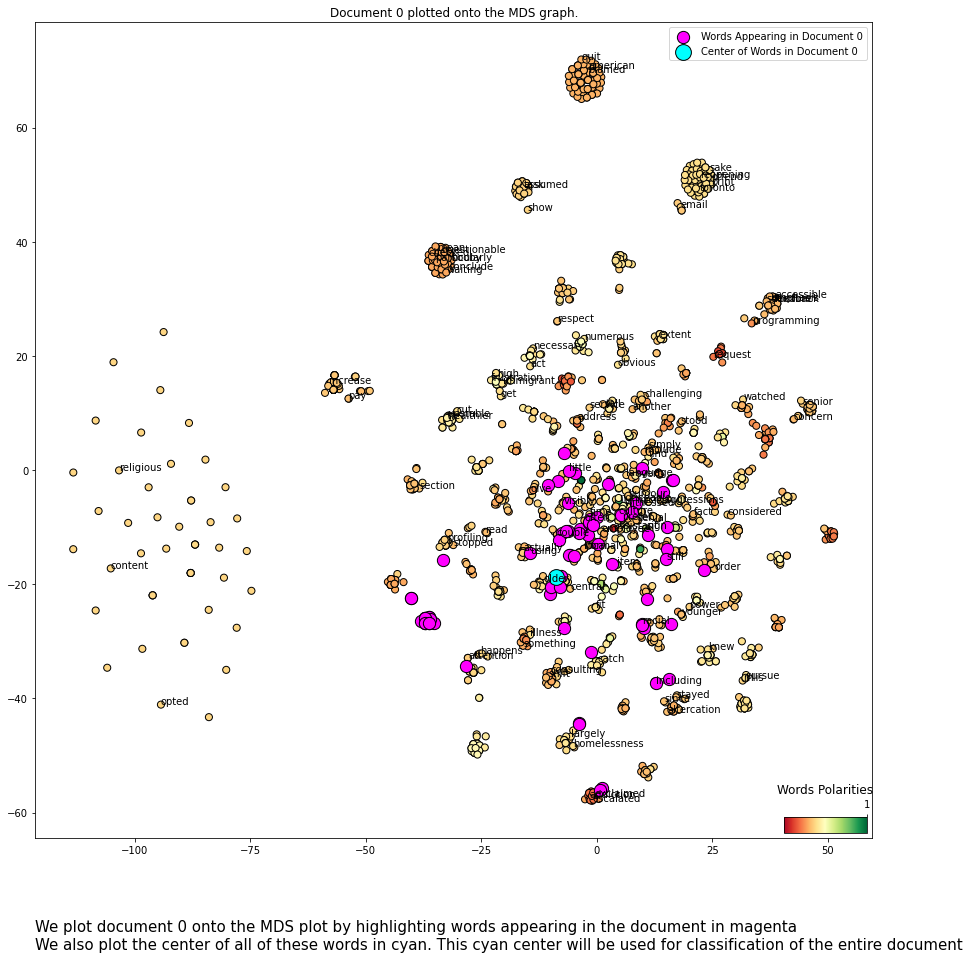

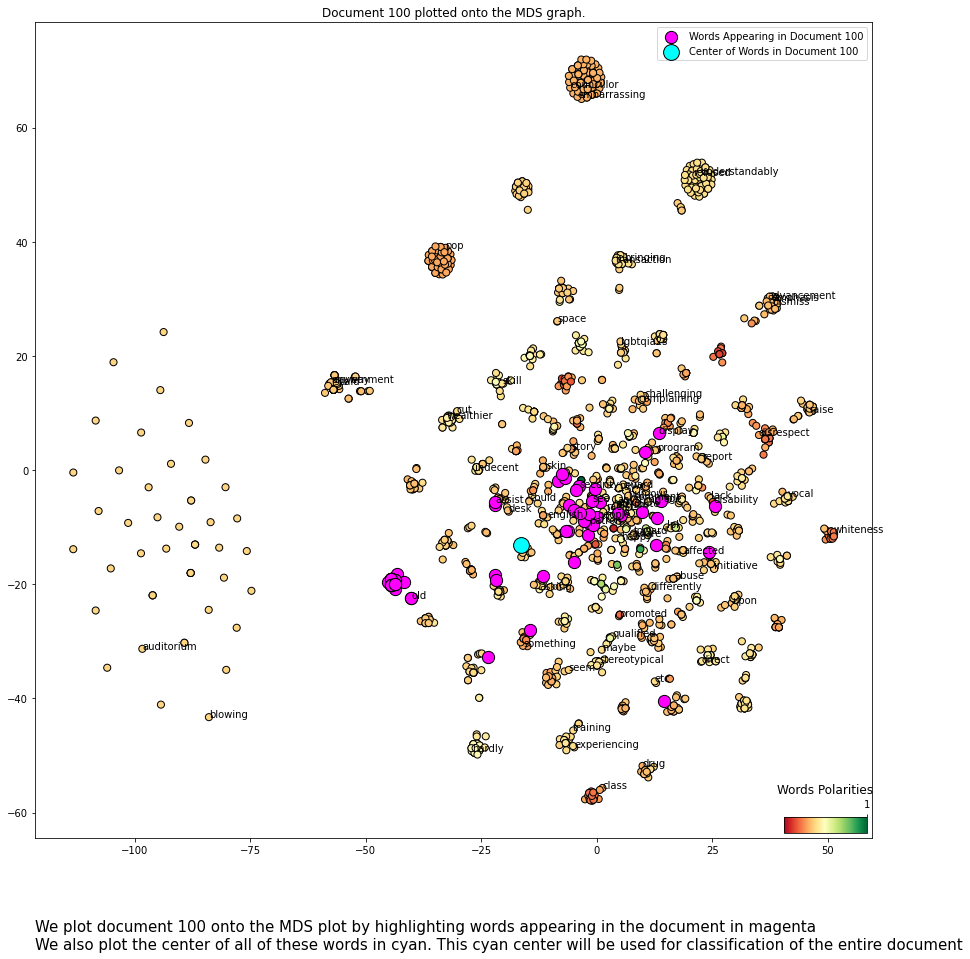

In [13]:
# arg_sorted = np.argsort(dists)
for i, c in enumerate(centers):
    if i % 100 == 0:
        desc = f'We plot document {i} onto the MDS plot by highlighting words appearing in the document in magenta \nWe also plot the center of all of these words in cyan. This cyan center will be used for classification of the entire document'
        save_fig_name = f'{DIR_NAME}{i}_doc{i}.png'
        plot_response(data, i, bow, labels, X_2d, num_clusters, clustering_algo, doc_labels, save_fig_name, desc)

# Classification
For this prototype, classification was done by manually setting a linear delimiter on the MDS graph, so document centers falling on one side of the line would be one category, and other falling on the other side would be another category

Performance of this method was evaluated by first setting subjective labels to each document, and then seeing how many document would be correctly classified. Labels were set as 1 if the response mentioned witnessing racism or being a victim of racism, and -1 otherwise.

We plot the linear seperator that goes diagonally through the graph. We also plot documents that are incorrectly in a class in magenta, and those that are correct in cyan

Text(0.5, 1.0, 'Polarities of No Risk Documents')

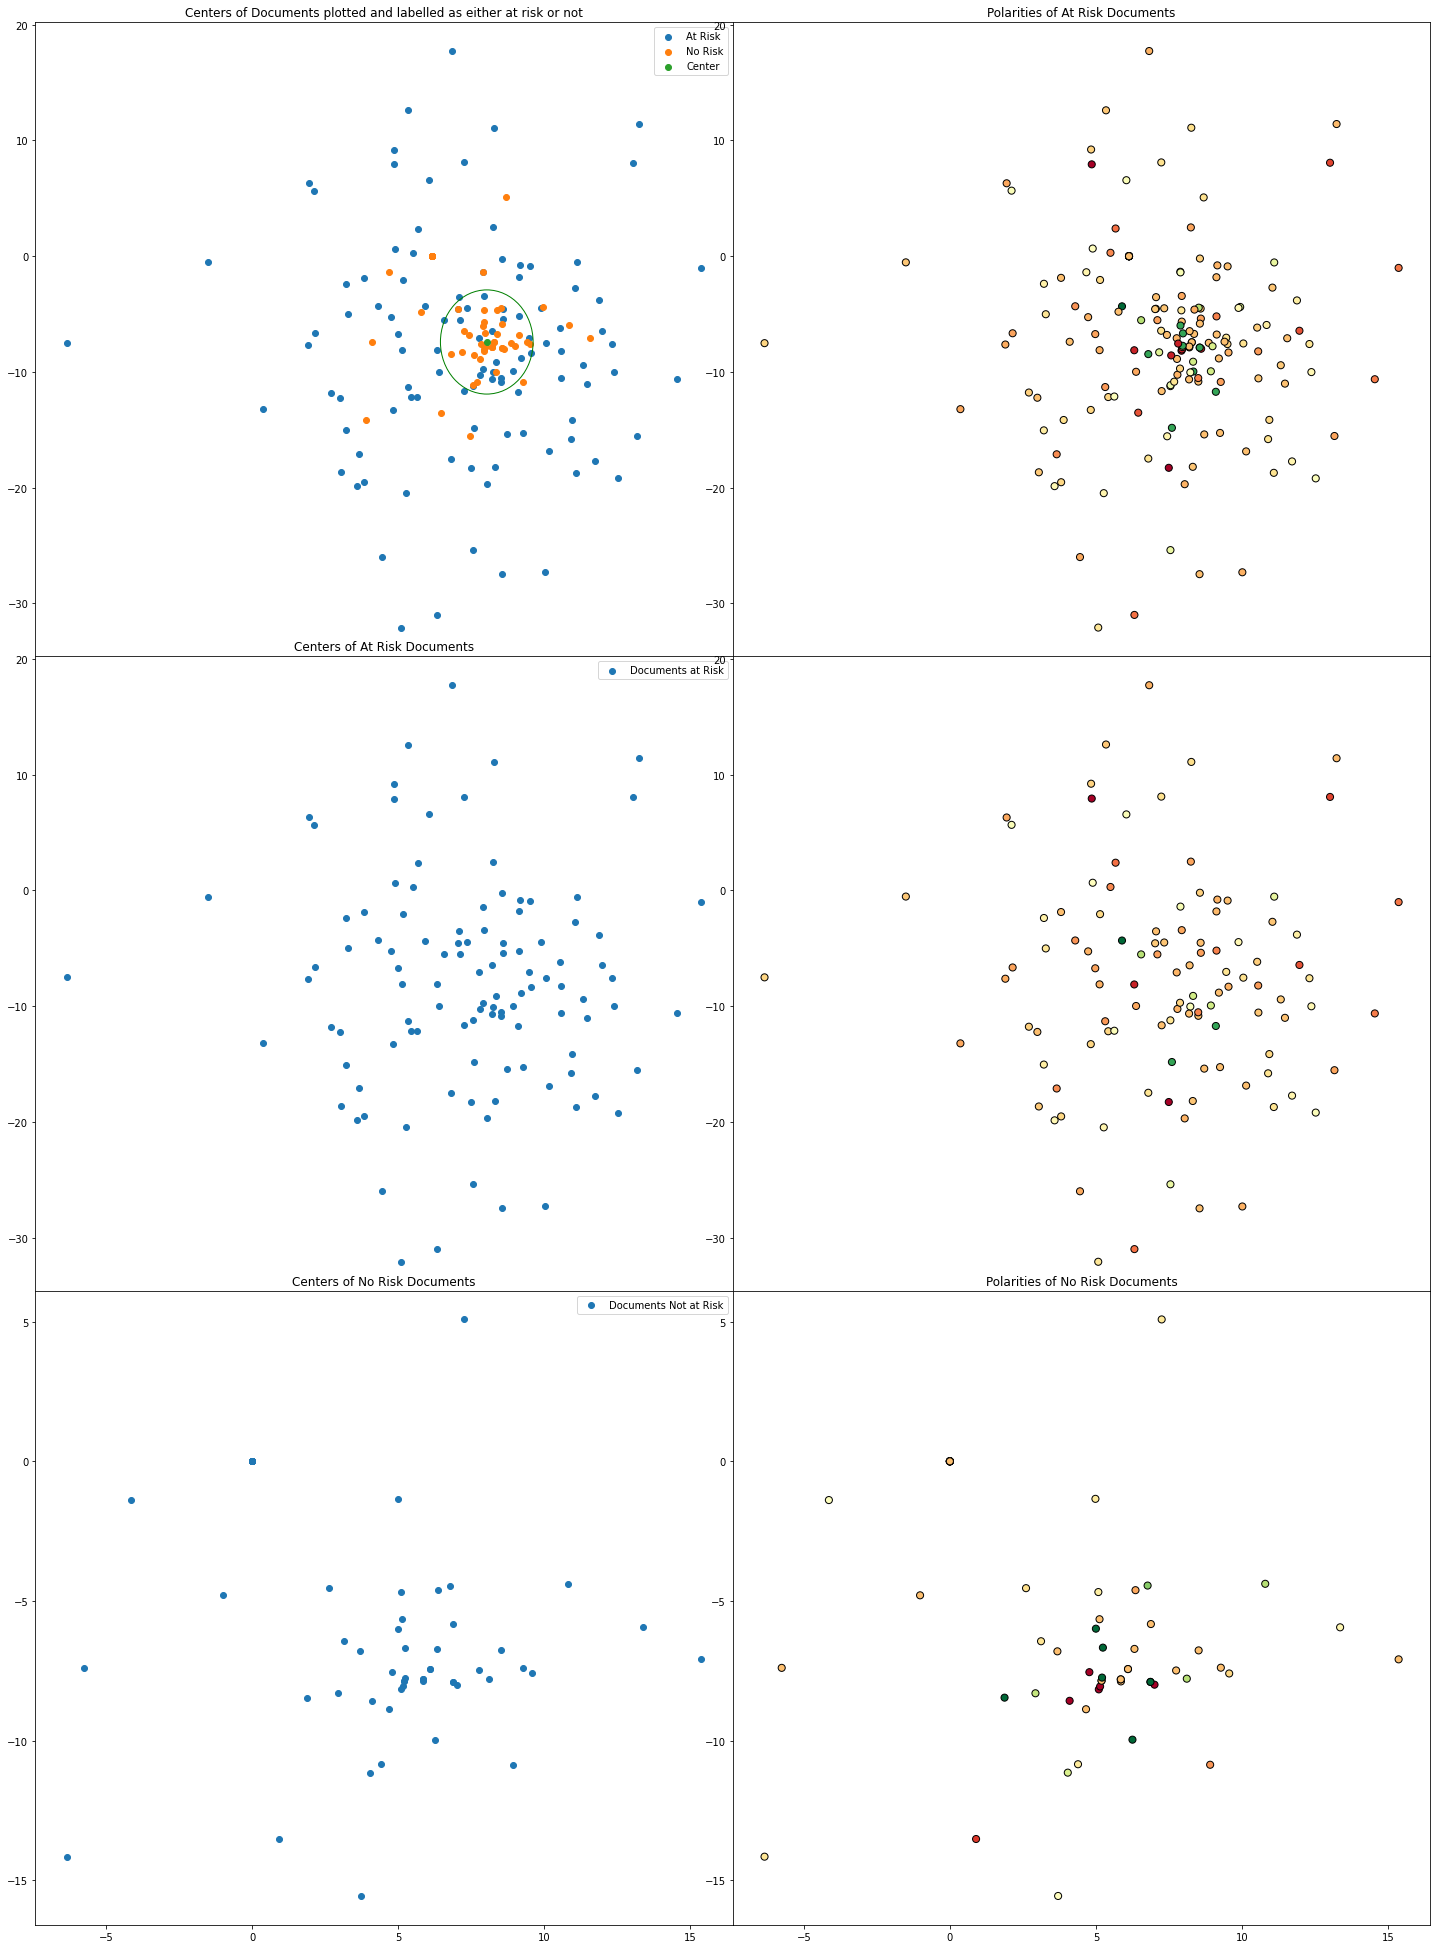

In [141]:
true_labels = pd.read_csv('labels_ambiguous.csv')
target_labels = np.array(true_labels['label'])
CIRCLE_RADIUS = 4.5
nonnan_centers = []
nonnan_doc_labels = []
nonnan_labels = []
for i, label in enumerate(target_labels):
    if not np.isnan(label):
        nonnan_centers.append(centers[i])
        nonnan_doc_labels.append(doc_labels[i])
        nonnan_labels.append(label)
        
nonnan_centers = np.array(nonnan_centers)
nonnan_doc_labels = np.array(nonnan_doc_labels)
nonnan_labels = np.array(nonnan_labels)

# Temporarily remove outlier to get a center
all_center = [np.mean(nonnan_centers[:,0]), np.mean(nonnan_centers[:,1])]
dists_to_doc_center = []
for c in nonnan_centers:
    dists_to_doc_center.append(distance(c, all_center))
dists_to_doc_center = np.array(dists_to_doc_center)
std_dev = np.std(dists_to_doc_center)
max_dev = 1

not_outlier = dists_to_doc_center < (max_dev * std_dev)
all_center = [np.mean(nonnan_centers[:,0][not_outlier]), np.mean(nonnan_centers[:,1][not_outlier])]


# Plot
fig = plt.figure(figsize=(25, 35))
gs = fig.add_gridspec(3, 2, hspace=0, wspace=0)
axes = gs.subplots()

axes[0,0].scatter(nonnan_centers[nonnan_labels == 1][:,0], nonnan_centers[nonnan_labels == 1][:,1], label='At Risk')
axes[0,0].scatter(nonnan_centers[nonnan_labels == 0][:,0], nonnan_centers[nonnan_labels == 0][:,1], label='No Risk')
axes[0,0].scatter(all_center[0], all_center[1], label='Center')
axes[0,0].set_title('Centers of Documents plotted and labelled as either at risk or not')

circle1 = plt.Circle((all_center[0], all_center[1]), CIRCLE_RADIUS, fc='none', ec='green')
axes[0,0].add_patch(circle1)

axes[0,0].legend()
axes[0,1].scatter(nonnan_centers[:,0], nonnan_centers[:,1],s=50, c=nonnan_doc_labels, cmap='RdYlGn', edgecolor='black')
axes[0,1].set_title('Polarities of Documents')


axes[1,0].scatter(nonnan_centers[nonnan_labels == 1][:,0], nonnan_centers[nonnan_labels == 1][:,1], label='Documents at Risk')
axes[1,0].set_title('Centers of At Risk Documents')
axes[1,0].legend()
axes[1,1].scatter(nonnan_centers[nonnan_labels == 1][:,0], nonnan_centers[nonnan_labels == 1][:,1],s=50, c=nonnan_doc_labels[nonnan_labels == 1], cmap='RdYlGn', edgecolor='black')
axes[0,1].set_title('Polarities of At Risk Documents')

axes[2,0].scatter(nonnan_centers[nonnan_labels == 0][:,0], nonnan_centers[nonnan_labels == 0][:,1], label='Documents Not at Risk')
axes[2,0].set_title('Centers of No Risk Documents')
axes[2,0].legend()
axes[2,1].scatter(nonnan_centers[nonnan_labels == 0][:,0], nonnan_centers[nonnan_labels == 0][:,1],s=50, c=nonnan_doc_labels[nonnan_labels == 0], cmap='RdYlGn', edgecolor='black')
axes[2,1].set_title('Polarities of No Risk Documents')


This graph was produced using the centers of documents from TSNE.

"center of document {i}" is the same as before: from the TSNE graph of words, take the points (words) that show up in document {i}. Find the center of these points --> this is the center of document {i}



I plotted all centers of document {i} and this is the graph that was produced. Blue is at risk documents (manually labeled), and orange is no risk document (manual label).



The green circle is manually created. The center of this green circle is the center of all the points on this graph. I classified points falling within this circle as "no risk", and others as "at risk", and that is where the 79% accuracy number comes from

In [144]:
df = {'true_label': [], 'predicted_label': [], 'risk': [], 'response': []}
attrition_labels = []
correct = 0
total = 0

j = 0
for i, center in enumerate(centers):
    true_label = true_labels.iloc[i]['label']
    if not np.isnan(true_label) and len(data[i].split(" ")) > 3:
        dist = abs(distance(center, all_center))
        if dist < CIRCLE_RADIUS:
            predicted_label = 0
        else:
            predicted_label = 1
        df['risk'].append(round(dist, 2))
        df['true_label'].append(true_label)
        df['predicted_label'].append(predicted_label)
        df['response'].append(data[i])
        if true_label == predicted_label:
            correct += 1
        j += 1
        total += 1
df = pd.DataFrame.from_dict(df)
print(f'Accuracy: {round((correct / total) * 100, 2)}%')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

df.sort_values(by=['risk'])

Accuracy: 78.81%


,true_label,predicted_label,risk
117,0.0,0,0.37
50,0.0,0,0.47
7,0.0,0,0.47
128,0.0,0,0.61
40,0.0,0,0.68
86,0.0,0,0.75
2,1.0,0,0.80
30,0.0,0,0.80
106,1.0,0,1.07
39,0.0,0,1.18
